# Impact Manifolds of Lagrange Point Orbits in CR3BP(-Polyhedron)

Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and
binary forms, with or without modification, are permitted exclusively
under the terms of the Modified BSD license. You should have received
a copy of the license with this file. If not, please or visit:
http://tudat.tudelft.nl/LICENSE.

## Context

This example demonstrates the setup and propagation of orbits and their invariant manifolds in the circular restricted three body problem (CR3BP) with polyhedral secondary. Additionally, it demonstrates the propagation of trajectories up to a surface impact (with the polyhedron), using hybrid termination conditions.

The invariant manifolds of a planar Lyapunov orbit around the L2 point of the Mars-Phobos system are computed. The system is modeled using the CR3BP with Mars' gravity being described by a point mass and Phobos' gravity by a polyhedron (since Phobos is a small, irregular moon). Phobos is considered to be tidally locked. The invariant manifolds are propagated until a maximum time, maximum distance to Phobos, or impact with Phobos (whatever happens first). The trajectories are propagated using a dimensionless state (with the typical CR3BP units of length and time).

The different trajectories are propagated with respect to a Mars-centered inertially-oriented frame, but analyzed with respect to a Phobos-centered rotating (synodic) frame.

## Import statements
The required import statements are made here.

Some standard modules are first loaded, these include `copy`, `numpy`, `matplotlib.pyplot`, and `os`.

Then, the different modules of `tudatpy` that will be used are imported.

In [1]:
# General imports
import copy
import numpy as np
import os
from matplotlib import pyplot as plt

# Tudatpy imports
import tudatpy
from tudatpy.util import result2array
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import propagation_setup, environment_setup, estimation_setup
from tudatpy.astro import polyhedron_utilities
from tudatpy.math import interpolators, root_finders
from tudatpy.astro.time_conversion import DateTime

## Auxiliary Functions

Since the CR3BP is being used, functions to compute the units of length and time used to make the CR3BP dimensionless are first defined.

In [2]:
########################################################################################################################
# Compute unit of length of the CR3BP
def cr3bp_unit_of_length (distance_between_primaries: float) -> float:
    return distance_between_primaries

########################################################################################################################
# Compute unit of time of the CR3BP
def cr3bp_unit_of_time (gravitational_parameter_primary: float,
                        gravitational_parameter_secondary: float,
                        distance_between_primaries: float) -> float:

    mean_motion = np.sqrt((gravitational_parameter_primary + gravitational_parameter_secondary) / \
                          distance_between_primaries ** 3)
    unit = 1/mean_motion

    return unit

In the CR3BP, trajectories are usually analyzed with respect to a synodic frame, i.e. a frame centered on the barycenter that rotates with the primaries (Mars and Phobos in this case). Instead of the usual barycentric synodic frame, here the synodic frame is considered to be Phobos centered (since orbits in the proximity of Phobos are being analyzed); therefore, the synodic frame coincides with Phobos' body-fixed frame. 

Since Tudat propagates the trajectories with respect to a frame with inertial origin and orientation, it is necessary to define functions to convert the state and state transition matrix (STM) to/from the body-fixed frame. The functions implemented here are valid for the conversion between an inertial frame and any **uniformly-rotating** (i.e. constant angular velocity) body-fixed frame.

In [3]:
########################################################################################################################
# Get full-state rotation matrix from inertial frame to body-fixed frame
def get_inertial_to_body_fixed_full_matrix(bodies: tudatpy.numerical_simulation.environment.SystemOfBodies,
                                           body_name: str,
                                           time: float) -> np.ndarray:

    inertial_to_body_fixed_matrix = bodies.get(body_name).rotation_model.inertial_to_body_fixed_rotation(time)
    inertial_to_body_fixed_matrix_derivative = bodies.get(body_name).rotation_model.time_derivative_inertial_to_body_fixed_rotation(time)

    inertial_to_body_fixed_full_matrix = np.zeros((6, 6))
    inertial_to_body_fixed_full_matrix[0:3,0:3] = inertial_to_body_fixed_matrix
    inertial_to_body_fixed_full_matrix[3:6,0:3] = inertial_to_body_fixed_matrix_derivative
    inertial_to_body_fixed_full_matrix[3:6,3:6] = inertial_to_body_fixed_matrix

    return inertial_to_body_fixed_full_matrix

########################################################################################################################
# Get full-state rotation matrix from body-fixed frame to inertial frame
def get_body_fixed_to_inertial_full_matrix(bodies: tudatpy.numerical_simulation.environment.SystemOfBodies,
                                           body_name: str,
                                           time: float) -> np.ndarray:

    body_fixed_to_inertial_matrix = bodies.get(body_name).rotation_model.body_fixed_to_inertial_rotation(time)
    body_fixed_to_inertial_matrix_derivative = bodies.get(body_name).rotation_model.time_derivative_body_fixed_to_inertial_rotation(time)

    body_fixed_to_inertial_full_matrix = np.zeros((6, 6))
    body_fixed_to_inertial_full_matrix[0:3,0:3] = body_fixed_to_inertial_matrix
    body_fixed_to_inertial_full_matrix[3:6,0:3] = body_fixed_to_inertial_matrix_derivative
    body_fixed_to_inertial_full_matrix[3:6,3:6] = body_fixed_to_inertial_matrix

    return body_fixed_to_inertial_full_matrix

########################################################################################################################
# Conversion of state from inertial to body-fixed frame
def convert_state_history_inertial_to_body_fixed(
        bodies: tudatpy.numerical_simulation.environment.SystemOfBodies,
        body_name: str,
        state_history_inertial: dict) -> dict:

    state_history_body_fixed = copy.deepcopy(state_history_inertial)

    for t in state_history_body_fixed.keys():
        body_state_inertial = bodies.get_body(body_name).state_in_base_frame_from_ephemeris(t)
        rotation_matrix = get_inertial_to_body_fixed_full_matrix(bodies, body_name, t)
        state_history_body_fixed[t] = rotation_matrix @ (state_history_inertial[t] - body_state_inertial)

    return state_history_body_fixed

########################################################################################################################
# Conversion of state from body-fixed to inertial frame
def convert_state_history_body_fixed_to_inertial(
        bodies: tudatpy.numerical_simulation.environment.SystemOfBodies,
        body_name: str,
        state_history_body_fixed: dict) -> dict:

    state_history_inertial = copy.deepcopy(state_history_body_fixed)

    for t in state_history_body_fixed.keys():
        body_state_inertial = bodies.get_body(body_name).state_in_base_frame_from_ephemeris(t)
        rotation_matrix = get_body_fixed_to_inertial_full_matrix(bodies, body_name, t)
        state_history_inertial[t] = rotation_matrix @ state_history_body_fixed[t] + body_state_inertial

    return state_history_inertial

########################################################################################################################
# Conversion state transition matrix from inertial to synodic frame
def convert_stm_history_inertial_to_body_fixed(
        bodies: tudatpy.numerical_simulation.environment.SystemOfBodies,
        body_name: str,
        stm_history_inertial: dict) -> dict:

    stm_history_body_fixed = copy.deepcopy(stm_history_inertial)

    body_fixed_to_inertial_matrix_initial = get_body_fixed_to_inertial_full_matrix(
        bodies, body_name, min(stm_history_inertial.keys()))

    for t in stm_history_inertial.keys():
        inertial_to_body_fixed_matrix_final = get_inertial_to_body_fixed_full_matrix(bodies, body_name, t)
        stm_history_body_fixed[t] = inertial_to_body_fixed_matrix_final @ stm_history_inertial[t] @ body_fixed_to_inertial_matrix_initial

    return stm_history_body_fixed

########################################################################################################################
# Conversion state transition matrix from inertial to synodic frame
def convert_stm_inertial_to_body_fixed(
        bodies: tudatpy.numerical_simulation.environment.SystemOfBodies,
        body_name: str,
        stm_inertial: np.ndarray,
        time_initial: float,
        time_final: float) -> np.ndarray:

    inertial_to_body_fixed_matrix_final = get_inertial_to_body_fixed_full_matrix(bodies, body_name, time_final)
    body_fixed_to_inertial_matrix_initial = get_body_fixed_to_inertial_full_matrix(bodies, body_name, time_initial)

    stm_synodic = inertial_to_body_fixed_matrix_final @ stm_inertial @ body_fixed_to_inertial_matrix_initial

    return stm_synodic

Finally, two functions are defined to create the propagator settings. 

The `create_time_termination_propagator_settings` function creates the settings for an orbit propagation that terminates at an exact time.

The `create_hybrid_termination_propagator_settings` function creates the settings for an orbit propagation with hybrid termination. This hybrid termination includes three possible termination conditions: maximum time, maximum distance to the origin of the secondary (Phobos), and impact with Phobos. The impact termination condition is defined using the Laplacian of the gravitational potential of the polyhedron. A given orbit propagation ends when one of these three conditions is met.

In [4]:
########################################################################################################################
# Create propagator settings for time termination
def create_time_termination_propagator_settings(central_bodies,
                                                acceleration_models,
                                                bodies_to_propagate,
                                                initial_state: np.ndarray,
                                                simulation_start_epoch,
                                                integrator_settings,
                                                simulation_end_epoch: float,
                                                dependent_variables_to_save: list):

    # Create propagation settings.
    termination_settings_time = propagation_setup.propagator.time_termination(
        simulation_end_epoch,
        terminate_exactly_on_final_condition=True)
    current_propagator = propagation_setup.propagator.encke

    propagator_settings = propagation_setup.propagator.translational(
        central_bodies,
        acceleration_models,
        bodies_to_propagate,
        initial_state,
        simulation_start_epoch,
        integrator_settings,
        termination_settings_time,
        propagator=current_propagator,
        output_variables=dependent_variables_to_save)

    return propagator_settings

########################################################################################################################
def create_hybrid_termination_propagator_settings(central_bodies,
                                                  acceleration_models,
                                                  bodies_to_propagate,
                                                  initial_state: np.ndarray,
                                                  simulation_start_epoch,
                                                  integrator_settings,
                                                  dependent_variables_to_save: list,
                                                  name_spacecraft: str,
                                                  name_secondary: str,
                                                  gravitational_parameter_secondary: float,
                                                  volume_secondary: float,
                                                  hybrid_termination_max_distance: float,
                                                  hybrid_termination_max_time: float):

    # Select target value of laplacian
    value = 2 * np.pi
    lower_bound_laplacian = - value * gravitational_parameter_secondary / volume_secondary

    # Create termination condition to detect impact (laplacian of polyhedron)
    termination_variable = propagation_setup.dependent_variable.gravity_field_laplacian_of_potential(
        name_spacecraft, name_secondary)
    root_finder_settings = root_finders.bisection(
        maximum_iteration=10,
        maximum_iteration_handling=root_finders.MaximumIterationHandling.accept_result)
    termination_settings_laplacian = propagation_setup.propagator.dependent_variable_termination(
        dependent_variable_settings=termination_variable,
        limit_value=lower_bound_laplacian,
        use_as_lower_limit=True,
        terminate_exactly_on_final_condition=True,
        termination_root_finder_settings=root_finder_settings)

    # Create termination condition based on maximum distance to secondary
    upper_bound_distance = hybrid_termination_max_distance
    termination_variable = propagation_setup.dependent_variable.relative_distance(name_spacecraft, name_secondary)
    root_finder_settings = root_finders.bisection(
        maximum_iteration=1,
        maximum_iteration_handling = root_finders.MaximumIterationHandling.accept_result)
    termination_settings_distance = propagation_setup.propagator.dependent_variable_termination(
          dependent_variable_settings = termination_variable,
          limit_value=upper_bound_distance,
          use_as_lower_limit=False,
          terminate_exactly_on_final_condition=True,
          termination_root_finder_settings=root_finder_settings)

    # Create termination condition based on propagation time
    termination_settings_time = propagation_setup.propagator.time_termination(
        hybrid_termination_max_time, terminate_exactly_on_final_condition=True)

    termination_conditions_list = [termination_settings_laplacian, termination_settings_distance, termination_settings_time]

    # Create hybrid termination condition
    termination_settings_hybrid = propagation_setup.propagator.hybrid_termination(
        termination_conditions_list, fulfill_single_condition=True)

    # Select propagator
    current_propagator = propagation_setup.propagator.cowell

    hybrid_termination_propagator_settings = propagation_setup.propagator.translational(
        central_bodies,
        acceleration_models,
        bodies_to_propagate,
        initial_state,
        simulation_start_epoch,
        integrator_settings,
        termination_settings_hybrid,
        propagator=current_propagator,
        output_variables=dependent_variables_to_save)

    return hybrid_termination_propagator_settings

## Model and Propagation Setup

To setup the used model (CR3BP with polyhedral secondary), it is first necessary to define a series of parameters. These include the gravitational parameters of Mars and Phobos, the semi-major axis of Phobos, the polyhedron of Phobos (coordinates of the vertices and vertices defining each facet), and the initial state and period of the used Lagrange point orbit. This periodic orbit was determined via continuation, which is currently not available via Tudat. This and other functionalities for the computation of periodic orbits will be added to Tudat in (near-ish) future.

Since all the trajectories are here propagated in dimensionless coordinates, all the dimensional parameters are made dimensionless using the units of time and length of the CR3BP.

In [5]:
####################################################################################################################
# Define dimensional model parameters and then make them dimensionless

name_primary = "Mars"
name_secondary = "Phobos"
name_spacecraft = "Spacecraft"

# Gravitational parameter of Mars
gravitational_parameter_primary = 4.2828372854e4 * 1e9 # m^3/s^2
# Gravitational parameter of Phobos
gravitational_parameter_secondary = 7.127e-4 * 1e9 # m^3/s^2
# Semi-major axis of Phobos
distance_between_primaries = 9375e3 # m

# Simplified polyhedron model
# Get coordinates of vertices, converting them from kilometers to meters
vertices_coordinates = np.loadtxt("input/phobos_500facets_vertices.txt") * 1e3
vertices_defining_each_facet = np.loadtxt("input/phobos_500facets_facets.txt", dtype=int)
# Rotate polyhedron model so that the x axis points in the anti-Mars direction, and the y-axis in the direction of orbital motion
vertices_coordinates[:,0] = -vertices_coordinates[:,0]
vertices_coordinates[:,1] = -vertices_coordinates[:,1]

# Correct vertices coordinates: center of mass coincident with origin
vertices_coordinates = polyhedron_utilities.modify_centroid(
    vertices_coordinates, vertices_defining_each_facet, desired_centroid=np.zeros(3) )

# Get CR3BP units
tu_cr3bp = cr3bp_unit_of_time(gravitational_parameter_primary, gravitational_parameter_secondary,
                              distance_between_primaries)
lu_cr3bp = cr3bp_unit_of_length(distance_between_primaries)

# Select hybrid termination conditions
hybrid_termination_max_time = 2 * np.pi * tu_cr3bp # 1 revolutions of the secondary
hybrid_termination_max_distance = 50e3 # km

# Make values dimensionless
gravitational_parameter_primary = gravitational_parameter_primary / lu_cr3bp**3 * tu_cr3bp**2
gravitational_parameter_secondary = gravitational_parameter_secondary / lu_cr3bp**3 * tu_cr3bp**2
distance_between_primaries = distance_between_primaries / lu_cr3bp
vertices_coordinates = vertices_coordinates / lu_cr3bp
hybrid_termination_max_time = hybrid_termination_max_time / tu_cr3bp
hybrid_termination_max_distance = hybrid_termination_max_distance / lu_cr3bp

####################################################################################################################
# Define dimensionless model parameters

# State and period of a planar Lyapunov orbit around the L2 point
# Specified in dimensionless coordinates wrt the secondary's body-fixed frame
initial_state_lpo_body_fixed = np.array(
    [2.023218488555800221e-03, -6.805660450040498197e-28, -2.809659056979557109e-05,
     -4.813620400827587031e-05, -1.486990610364946619e-03, 3.598307742062465862e-04])
period_lpo = 3.032280964384842736e+00

simulation_start_epoch = DateTime(2000, 1, 1).epoch()

manifolds_position_perturbation = 1e-6

# Define settings for manifold propagation
no_manifold_nodes = 50

# Compute dimensionless volume
volume_secondary = polyhedron_utilities.volume(vertices_coordinates, vertices_defining_each_facet)

Next, the used system of bodies is created according to the assumptions of the CR3BP with polyhedral secondary:

* Mars: located at origin of reference frame and having point mass gravity 
* Phobos: moving in circular orbit around the Mars, and having uniformly-rotating polyhedron gravity. Therefore, the polyhedron rotates with the same angular velocity of Phobos' orbit around Mars.
* Spacecraft: body with zero mass

In [6]:
####################################################################################################################
# Create system of bodies    

# Initial state of primary in CR3BP, with primary as propagation/ephemeris origin
initial_state_keplerian_primary = np.zeros(6)
# Initial state of secondary in CR3BP, with primary as propagation/ephemeris origin
initial_state_keplerian_secondary = np.zeros(6)
initial_state_keplerian_secondary[0] = distance_between_primaries

# Frame origin and orientation
global_frame_origin = name_primary
global_frame_orientation = "ECLIPJ2000"

# Define body settings
body_settings = environment_setup.BodyListSettings(global_frame_origin, global_frame_orientation)

# Primary
body_settings.add_empty_settings(name_primary)
# Gravity: point mass
body_settings.get(name_primary).gravity_field_settings = environment_setup.gravity_field.central(
    gravitational_parameter_primary)
# Ephemeris: primary at origin -> constant ephemeris
body_settings.get(name_primary).ephemeris_settings = environment_setup.ephemeris.constant(
    initial_state_keplerian_primary,
    "SSB",
    global_frame_orientation)

# Secondary
body_settings.add_empty_settings(name_secondary)
body_frame_secondary = name_secondary + "_Fixed"
# Gravity: polyhedron
body_settings.get(name_secondary).gravity_field_settings = environment_setup.gravity_field.polyhedron_from_mu(
    gravitational_parameter=gravitational_parameter_secondary,
    vertices_coordinates=vertices_coordinates,
    vertices_defining_each_facet=vertices_defining_each_facet,
    associated_reference_frame=body_frame_secondary)
# Ephemeris: secondary has circular orbit around primary
body_settings.get(name_secondary).ephemeris_settings = environment_setup.ephemeris.keplerian(
    initial_state_keplerian_secondary,
    simulation_start_epoch,
    gravitational_parameter_primary + gravitational_parameter_secondary)
# Rotation model: tidally locked
# Using "simple" instead of "synchronous" model because the latter doesn't have the derivatives of the rotation
# matrix implemented tudat
rotation_rate = 1 / cr3bp_unit_of_time(
    gravitational_parameter_primary, gravitational_parameter_secondary, distance_between_primaries)
body_settings.get(name_secondary).rotation_model_settings = environment_setup.rotation_model.simple(
    base_frame="ECLIPJ2000",
    target_frame=body_frame_secondary,
    initial_orientation=np.eye(3),
    initial_time=simulation_start_epoch,
    rotation_rate=rotation_rate)

# Spacecraft
body_settings.add_empty_settings(name_spacecraft)
body_settings.get(name_spacecraft).constant_mass = 0.0

# Create system of selected celestial bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

The acceleration models are now created. As mentioned, the primary (Mars) has point mass gravity and the secondary (Phobos) has polyhedral gravity.

In [7]:
####################################################################################################################
# Create acceleration models

# Define bodies that are propagated.
bodies_to_propagate = [name_spacecraft]
# Define central bodies.
central_bodies = [name_primary]

# Define accelerations acting on spacecraft
acceleration_settings_on_spacecraft = {
    name_primary: [propagation_setup.acceleration.point_mass_gravity()],
    name_secondary: [propagation_setup.acceleration.polyhedron_gravity()]
}

# Create global accelerations settings dictionary.
acceleration_settings = {name_spacecraft: acceleration_settings_on_spacecraft}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies)

Next, the settings of the integrator are defined. A variable-step RKDP8(7) integrator is used. 

In [8]:
####################################################################################################################
# Create integrator settings

current_coefficient_set = propagation_setup.integrator.CoefficientSets.rkdp_87
# Define absolute and relative tolerance
current_tolerance = 1e-12
initial_time_step = 1e-6
# Maximum step size: inf; minimum step size: eps
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    initial_time_step, current_coefficient_set, np.finfo(float).eps, np.inf,
    current_tolerance, current_tolerance)

Finally, the dependent variables to save during the propagation are selected. Here, no dependent variable is saved, though the code can be modified to do so if desired.

In [9]:
####################################################################################################################
# Select dependent variables

dependent_variables_to_save = []

## Propagation of the Lagrange point orbit

Having defined the model to use, it is finally possible to propagate the Lagrange point orbit from which the invariant manifolds will depart. Recall that the initial state and period of this orbit was defined above. Since this initial state was defined with respect to Phobos' body-fixed frame, it is first necessary to convert it to the inertial frame. 

Next, the propagator settings are created using the `create_time_termination_propagator_settings` function: these settings define the propagation of the orbit to an exact final time (the period of the orbit). 

Having the propagator settings and the initial state in the inertial frame, it is now possible to propagate the orbit. The `create_variational_equations_solver` is used, to allow the propagation of the STM (necessary for computing the invariant manifolds).

After the propagation is finished, the state and STM histories with respect to the inertial frame are retrieved and converted to the body-fixed frame.

In [10]:
####################################################################################################################
# Propagate lagrange point orbit with variational equations

# Get initial state in the inertial frame
state_history_lpo_inertial = convert_state_history_body_fixed_to_inertial(
    bodies, name_secondary, {simulation_start_epoch: initial_state_lpo_body_fixed})

# Create propagator settings
time_propagator_settings = create_time_termination_propagator_settings(
    central_bodies, acceleration_models, bodies_to_propagate, state_history_lpo_inertial[simulation_start_epoch],
    simulation_start_epoch, integrator_settings, period_lpo, dependent_variables_to_save)

# Propagate variational equations, propagating just the STM
parameter_settings = estimation_setup.parameter.initial_states(time_propagator_settings, bodies)
lpo_single_arc_solver = numerical_simulation.create_variational_equations_solver(
        bodies, time_propagator_settings,
        estimation_setup.create_parameter_set(parameter_settings, bodies),
        simulate_dynamics_on_creation=True)

# Retrieve state and STM history and convert them to body-fixed frame
state_history_lpo_inertial = lpo_single_arc_solver.state_history
stm_history_lpo_inertial = lpo_single_arc_solver.state_transition_matrix_history

state_history_lpo_body_fixed = convert_state_history_inertial_to_body_fixed(
    bodies, name_secondary, state_history_lpo_inertial)
stm_history_lpo_body_fixed = convert_stm_history_inertial_to_body_fixed(
    bodies, name_secondary, stm_history_lpo_inertial)

## Propagation of the invariant manifolds

Having propagated an unstable Lagrange point orbit, its invariant manifolds are now computed. Only the unstable invariant manifolds are propagated; the stable ones can be obtained in a similar way, but using a negative time step instead (backward propagation). 

The initial state of each manifold branch can be obtained by perturbing the state at a node of the orbit with the most unstable eigenvector of the monodromy matrix associated with that node, which corresponds to the eigenvector associated with the eigenvalue with the largest norm.

Since the linearized dynamics are being considered via the STM, one can instead use the monodromy matrix just to determine the unstable eigenvector at the 1st node. The unstable eigenvectors at the remaining nodes of the orbit can then be obtained using the STM. However, to do that, one needs to know the state and STM at each node of the orbit, which here is done using an interpolator. This allow having nodes equally spaced in time along the orbit. A 4th order Lagrange interpolator is used.

In [11]:
####################################################################################################################
# Propagate the invariant manifolds

lpo_initial_time = min(state_history_lpo_body_fixed.keys())
lpo_final_time = max(state_history_lpo_body_fixed.keys())

# Get monodromy matrix
monodromy_matrix_body_fixed = stm_history_lpo_body_fixed[lpo_final_time]
# Get unstable eigenvector of monodromy matrix
eigenvalues, eigenvectors = np.linalg.eig(monodromy_matrix_body_fixed)
unstable_eigenvector_id = np.argmax(np.abs(eigenvalues))
unstable_eigenvector = eigenvectors[:, unstable_eigenvector_id]

# Create STM interpolator
interpolator_settings = interpolators.lagrange_interpolation(4)
stm_history_lpo_body_fixed_interpolator = interpolators.create_one_dimensional_matrix_interpolator(
    stm_history_lpo_body_fixed, interpolator_settings)
# Create state interpolator
state_history_lpo_body_fixed_interpolator = interpolators.create_one_dimensional_vector_interpolator(
    state_history_lpo_body_fixed, interpolator_settings)

Having defined the interpolators, it is now possible to loop over the nodes of the Lagrange point orbit and determine the initial state of the unstable invariant manifold at each of them. This initial state is defined with respect to Phobos' body-fixed frame, so it needs to be converted to the inertial frame before executing the propagation.

Next, the propagator settings are created. Hybrid propagator settings are used, which terminate the propagation after a maximum time or maximum distance to Phobos is reached, or after the spacecraft impacts Phobos (whatever happens first). Finally, the `create_dynamics_simulator` function is called to propagate each manifold.

The two manifold branches (i.e. initial state of the manifold obtained by a positive or negative perturbation) of the orbit are here propagated.

In [12]:
# Loop over manifold nodes and propagate the manifold
manifold_single_arc_solvers = [[],[]]
for manifold_direction_to_propagate in [-1, 1]:
    for i in range(no_manifold_nodes):
        # Deal with i=0 differently to avoid cases with numerical errors in the initial time
        if i == 0:
            current_state = state_history_lpo_body_fixed[lpo_initial_time]
            current_unstable_eigenvector = unstable_eigenvector
        # Compute unstable eigenvector at current node
        else:
            time_since_arc_start = i * (lpo_final_time - lpo_initial_time) / no_manifold_nodes
            current_state = state_history_lpo_body_fixed_interpolator.interpolate(time_since_arc_start)
            current_stm = stm_history_lpo_body_fixed_interpolator.interpolate(time_since_arc_start)
            current_unstable_eigenvector = current_stm @ unstable_eigenvector
            current_unstable_eigenvector = current_unstable_eigenvector / np.linalg.norm(current_unstable_eigenvector)

        # Sanity check
        if not np.all(np.imag(current_unstable_eigenvector) == 0):
            raise RuntimeError("Error when creating manifold initial state: eigenvector has imaginary components")
        else:
            current_unstable_eigenvector = np.real(current_unstable_eigenvector)

        # Compute initial state of manifold
        manifold_initial_state_body_fixed = current_state + manifold_direction_to_propagate * manifolds_position_perturbation / \
                                            np.linalg.norm(current_unstable_eigenvector[0:3]) * current_unstable_eigenvector

        # Get initial state in the inertial frame
        state_history_manifold_inertial = convert_state_history_body_fixed_to_inertial(
            bodies, name_secondary,
            {simulation_start_epoch: manifold_initial_state_body_fixed})

        # Create propagator settings
        hybrid_propagator_settings = create_hybrid_termination_propagator_settings(
            central_bodies, acceleration_models, bodies_to_propagate, state_history_manifold_inertial[simulation_start_epoch],
            simulation_start_epoch, integrator_settings, dependent_variables_to_save, name_spacecraft, name_secondary, gravitational_parameter_secondary,
            volume_secondary, hybrid_termination_max_distance, hybrid_termination_max_time)

        # Propagate manifold
        manifold_single_arc_solver = numerical_simulation.create_dynamics_simulator(
            bodies, hybrid_propagator_settings)

        if manifold_direction_to_propagate == -1:
            manifold_single_arc_solvers[0].append(manifold_single_arc_solver)
        else:
            manifold_single_arc_solvers[1].append(manifold_single_arc_solver)

## Plotting the results

Finally, we can plot the computed orbit and its manifolds. Before plotting the manifolds, their state history is retrieved from the single arc solver and converted to the body-fixed frame. 

Phobos' shape is also plotted, using the `tricontourf` function.

Text(0, 0.5, 'z [km]')

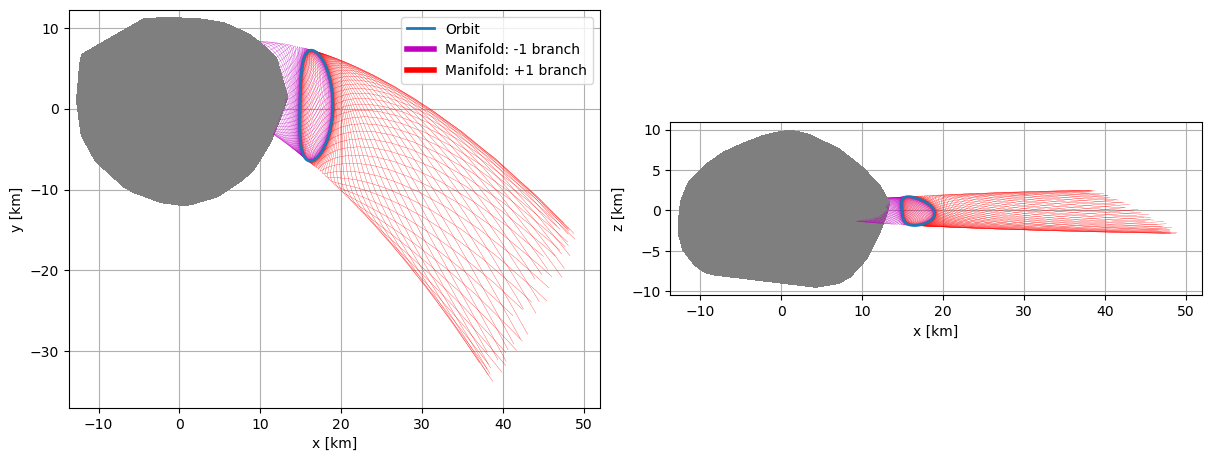

In [13]:
####################################################################################################################
# Make plot: x vs y, x vs z

fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)

state_history_lpo_body_fixed_array = result2array(state_history_lpo_body_fixed)[:,1:]

# Plot orbit
ax[0].plot(state_history_lpo_body_fixed_array[:, 0] * lu_cr3bp/1e3,
           state_history_lpo_body_fixed_array[:, 1] * lu_cr3bp/1e3, lw=2, zorder=10, label="Orbit")
ax[1].plot(state_history_lpo_body_fixed_array[:, 0] * lu_cr3bp/1e3,
           state_history_lpo_body_fixed_array[:, 2] * lu_cr3bp/1e3, lw=2, zorder=10)

for manifold_branch_id in [0,1]:
    for single_arc_solver in manifold_single_arc_solvers[manifold_branch_id]:

        # Extract manifold state history and convert it to body-fixed frame
        state_history_manifold_inertial = single_arc_solver.state_history
        state_history_manifold_body_fixed = convert_state_history_inertial_to_body_fixed(
            bodies, name_secondary, state_history_manifold_inertial)
        state_history_manifold_body_fixed_array = result2array(state_history_manifold_body_fixed)[:,1:]

        if manifold_branch_id == 0:
            c = "m"
        else:
            c = "r"

        if state_history_manifold_body_fixed_array[-1,1] > 0:
            zorder_y = 6
        else:
            zorder_y = 4

        if state_history_manifold_body_fixed_array[-1,2] > 0:
            zorder_z = 6
        else:
            zorder_z = 4

        # Plot manifold
        ax[0].plot(state_history_manifold_body_fixed_array[:, 0] * lu_cr3bp/1e3,
                   state_history_manifold_body_fixed_array[:, 1] * lu_cr3bp/1e3, lw=0.2, c=c, zorder=zorder_z)
        ax[1].plot(state_history_manifold_body_fixed_array[:, 0] * lu_cr3bp/1e3,
                   state_history_manifold_body_fixed_array[:, 2] * lu_cr3bp/1e3, lw=0.2, c=c, zorder=zorder_y)

# Add label to manifolds
ax[0].plot([np.nan], [np.nan], label="Manifold: -1 branch", c="m", lw=4)
ax[0].plot([np.nan], [np.nan], label="Manifold: +1 branch", c="r", lw=4)

# Plot the shape of the secondary
ax[0].tricontourf(vertices_coordinates[:,0] * lu_cr3bp/1e3, vertices_coordinates[:,1] * lu_cr3bp/1e3,
                  np.zeros(np.shape(vertices_coordinates[:,0])), colors="tab:grey", zorder=5)
ax[1].tricontourf(vertices_coordinates[:,0] * lu_cr3bp/1e3, vertices_coordinates[:,2] * lu_cr3bp/1e3,
                  np.zeros(np.shape(vertices_coordinates[:,0])), colors="tab:grey", zorder=5)

for ax_ in ax:
    ax_.set_xlabel('x [km]')
    ax_.grid()
    ax_.set_axisbelow(True)
    ax_.set_aspect('equal')

    ax_.set_xlim(left=ax_.get_xlim()[0] - 1)
    ax_.set_ylim(bottom=ax_.get_ylim()[0] - 1)
    ax_.set_ylim(top=ax_.get_ylim()[1] + 1)

ax[0].legend()
ax[0].set_ylabel('y [km]')
ax[1].set_ylabel('z [km]')